In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/tmp/ipykernel_1181/3184238933.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
from tensorflow.python.keras.applications import ResNet50

2024-02-07 13:36:36.990508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 13:36:36.990539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 13:36:37.017543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 13:36:37.086924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 13:36:37.733028: W tensorflow/compiler/tf2

In [3]:
filenames = os.listdir('kaggle/dogs-vs-cats-redux-kernels-edition/train')
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

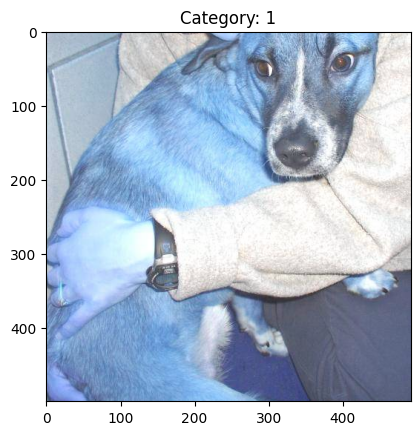

In [4]:
index = np.random.choice(df.index)
filename = df.loc[index, 'filename']
category = df.loc[index, 'category']
img = cv2.imread('kaggle/dogs-vs-cats-redux-kernels-edition/train/' + filename)
plt.imshow(img)
plt.title(f'Category: {category}')
plt.show()
# test

In [5]:
df

,filename,category
0,cat.5663.jpg,0
1,dog.11277.jpg,1
2,cat.1240.jpg,0
3,dog.5978.jpg,1
4,cat.365.jpg,0
...,...,...
24995,dog.11600.jpg,1
24996,cat.9071.jpg,0
24997,dog.8132.jpg,1
24998,cat.5560.jpg,0


In [6]:
train_df,validate_df = train_test_split(df,train_size = 0.7, random_state = 42)
batch_size = 64

img_size = (128, 128)
channels = 3
img_shape = (img_size[0],img_size[1],channels)

In [7]:
# Create different ImageDataGenerator objects for training and testing/validation sets
tr_gen = ImageDataGenerator(rescale=1./255, 
                               shear_range=0.15, 
                               zoom_range=0.2, 
                               horizontal_flip=True)
ts_gen = ImageDataGenerator(rescale=1./255 )

In [8]:
# Specify the directory argument for each set
train_gen = tr_gen.flow_from_dataframe(dataframe = train_df, directory = 'kaggle/dogs-vs-cats-redux-kernels-edition/train',x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb'
                                      , shuffle = True, batch_size = batch_size)
validate_gen = ts_gen.flow_from_dataframe(dataframe = validate_df, directory = 'kaggle/dogs-vs-cats-redux-kernels-edition/train', x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb'
                                      , shuffle = True, batch_size = batch_size)

Found 17500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_18 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 conv2d_20 (Conv2D)          (None, 58, 58, 64)       

In [17]:
# early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model2.h5', save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(x= train_gen, epochs = 50 ,verbose = 1,validation_data = validate_gen, callbacks=[model_checkpoint])

Epoch 1/50
274/274 [==============================] - 33s 121ms/step - loss: 0.2534 - accuracy: 0.8929 - val_loss: 0.3937 - val_accuracy: 0.8525
Epoch 2/50
274/274 [==============================] - 33s 120ms/step - loss: 0.2480 - accuracy: 0.8958 - val_loss: 0.3807 - val_accuracy: 0.8579
Epoch 3/50
274/274 [==============================] - 33s 120ms/step - loss: 0.2504 - accuracy: 0.8937 - val_loss: 0.3331 - val_accuracy: 0.8693
Epoch 4/50
274/274 [==============================] - 33s 120ms/step - loss: 0.2411 - accuracy: 0.9002 - val_loss: 0.3915 - val_accuracy: 0.8573
Epoch 5/50
274/274 [==============================] - 33s 119ms/step - loss: 0.2464 - accuracy: 0.8983 - val_loss: 0.4007 - val_accuracy: 0.8507
Epoch 6/50
274/274 [==============================] - 33s 121ms/step - loss: 0.2379 - accuracy: 0.9010 - val_loss: 0.4229 - val_accuracy: 0.8371
Epoch 7/50
274/274 [==============================] - 33s 120ms/step - loss: 0.2359 - accuracy: 0.9027 - val_loss: 0.5539 - val_ac